# Software profesional en Acústica 2020-21 (M2i)

*This notebook contains an excerpt (with slight modifications) from Section 23.3 in the [Python Programming and Numerical Methods - A Guide for Engineers and Scientists](https://www.elsevier.com/books/python-programming-and-numerical-methods/kong/978-0-12-819549-9), the content is also available at [Berkeley Python Numerical Methods](https://pythonnumericalmethods.berkeley.edu/notebooks/Index.html).The copyright of the book belongs to Elsevier. We also have this interactive book online for a better learning experience. The code is released under the [MIT license](https://opensource.org/licenses/MIT).*

# Finite Difference Method

Another way to solve the ODE and PDE boundary value problems is the **finite difference method**, where we can use finite difference formulas at evenly spaced grid points to approximate the differential equations (in this case in an one-dimensional case). This way, we can transform a differential equation into a system of algebraic equations to solve. 

In the finite difference method, the derivatives in the differential equation are approximated using the finite difference formulas. We can divide the the interval of $[a, b]$ into $n$ equal subintervals of length $h$ as shown in the following figure. 

<img src="images/23.03.01-Finite-difference.png" alt="finite difference" title="Finite difference grids" width="500"/>

Commonly, we usually use the central difference formulas in the finite difference methods due to the fact that they yield better accuracy. The differential equation is enforced only at the grid points, and the first and second derivatives are:

$$\frac{du}{dx} = \frac{u_{i+1}-u_{i-1}}{2h} + O(h)$$

$$\frac{d^2u}{dx^2} = \frac{u_{i-1}-2u_i+u_{i+1}}{h^2} + O(h^2)$$

These finite difference expressions are used to replace the derivatives of $u$ in the differential equation which leads to a system of $n+1$ linear algebraic equations if the differential equation is linear. If the differential equation is nonlinear, the algebraic equations will also be nonlinear.  

**EXAMPLE:** Solve the Helmholtz problem using the finite difference method, and plot the numerical approximation. The ODE is
$$ -\frac{d^2u}{dx^2} - k^2u = 0$$
with the boundary conditions $u(0) = 0$ and $u(\pi) = 1$. Let's take $n=10$. 

Since the time interval is $[0, \pi]$ and we have $n=10$, therefore, $h=\pi/n$, using the finite difference approximated derivatives, we have 

$$ u_0 = 0$$

$$ -\frac{u_{i-1} - 2u_i + u_{i+1}}{h^2} -k^2\frac{u_{i-1} + 2u_i + u_{i+1}}{4}=0, \;i = 1, 2, ..., n-1$$

$$ u_{10} = 1$$

If we use matrix notation, we will have:

$$
\left(\begin{bmatrix}
1 & 0 & & & \\
1 & -2 & 1 & &  \\
 & \ddots & \ddots & \ddots & \\
 & & 1& -2& 1 \\
 & & & 0 & 1
\end{bmatrix}
+
\frac{k^2h^2}{4}
\begin{bmatrix}
2 & 1 & & & \\
1 & 2 & 1 & &  \\
 & \ddots & \ddots & \ddots & \\
 & & 1& 2& 1 \\
 & & & 1 & 2
\end{bmatrix}
\right)
\left[\begin{array}{c} u_0 \\u_1 \\ ... \\ u_{n-1}\\u_n \end{array}\right] =
\left[\begin{array}{c} 0 \\0 \\ ... \\ 0 \\1\end{array}\right]$$

Therefore, we have $n+1$ equations in the system, we can store it using a sparse matrix (tridiagonal), and solve it using the sparse linear solver included in ``scipy``. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[[ 1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 1.05551652 -1.88896695  1.05551652  0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          1.05551652 -1.88896695  1.05551652  0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.05551652 -1.88896695  1.05551652  0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.05551652 -1.88896695  1.05551652
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.05551652 -1.88896695
   1.05551652  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.05551652
  -1.88896695  1.05551652  0.          0.          0.        ]
 [ 0.          0.          0.         

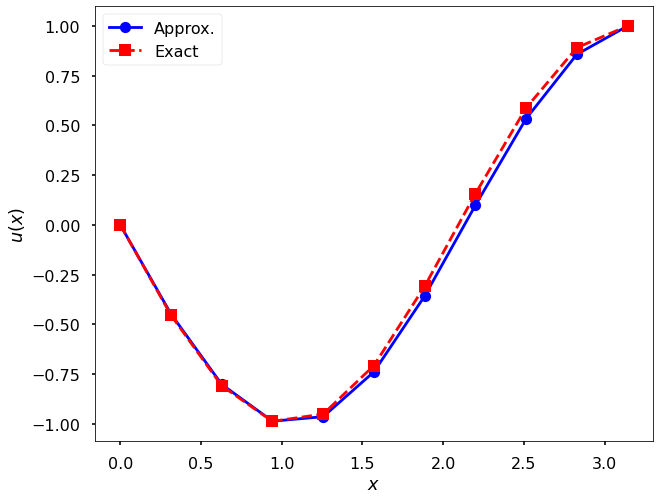

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve

# Setting matplotlib
plt.style.use('seaborn-poster')
%matplotlib inline

# Physical setting
a = np.pi # lenght interval
k = 1.5 # wavenumber

# Discretization size
n = 10
h = a / n

# Compute K
data = np.array([-2*np.ones(n+1), np.ones(n+1), np.ones(n+1)])
diags = np.array([0, -1, 1])
K = spdiags(data, diags, n+1, n+1).tocsr()
                 
# Compute M
data = np.array([0.5*np.ones(n+1), 0.25*np.ones(n+1), 0.25*np.ones(n+1)])
diags = np.array([0, -1, 1])
M = spdiags(data, diags, n+1, n+1).tocsr()

# Get discretization matrix
A = K +(k*h)**2*M

# Get b
b = np.zeros(n+1)

# Block the boundary conditions on b
b[0] = 0.
b[-1] = 1.
print(b)

# Block the boundary conditions on A
A[0,0] = 1.; A[0,1] = 0.
A[-1,-1] = 1.; A[-1,-2] = 0.
print(A.toarray())

# solve the linear equations
u = spsolve(A, b)

# Plot the solution
x = np.linspace(0, a, n+1)
plt.figure(figsize=(10,8))
plt.plot(x, u, 'bo-')
plt.plot(x, -np.sin(k*x), 'rs--')
plt.xlabel(r'$x$')
plt.ylabel(r'$u(x)$')
plt.legend(['Approx.','Exact'])
plt.show()

Now, we are going to check the order of convergence of the method with respect to the grid size $h$ using a more programatically implementation (with functions ``compute_fd(n)`` and ``compute_exact(n)``, being $n+1$ the number of grid points): 

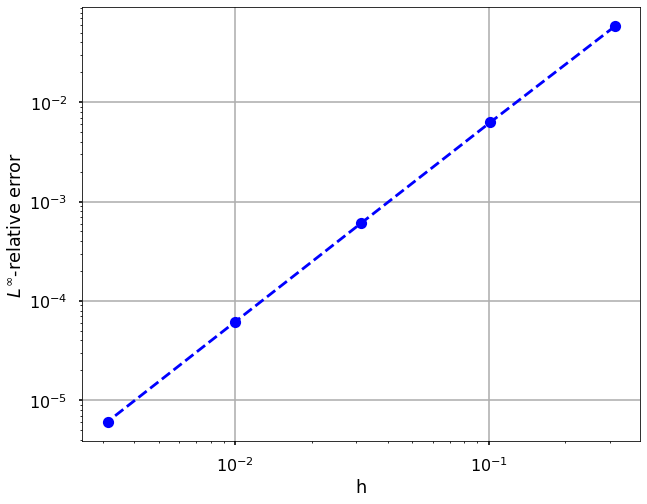

In [9]:
def compute_fd(n):

    # Physical setting
    a = np.pi # lenght interval
    k = 1.5 # wavenumber
    
    # Discretization size
    h = a / n

    # Compute K
    data = np.array([-2*np.ones(n+1), np.ones(n+1), np.ones(n+1)])
    diags = np.array([0, -1, 1])
    K = spdiags(data, diags, n+1, n+1).tocsr()
                 
    # Compute M
    data = np.array([0.5*np.ones(n+1), 0.25*np.ones(n+1), 0.25*np.ones(n+1)])
    diags = np.array([0, -1, 1])
    M = spdiags(data, diags, n+1, n+1).tocsr()

    # Get discretization matrix
    A = K +(k*h)**2*M

    # Get b
    b = np.zeros(n+1)

    # Block the boundary conditions on b
    b[1] = 0.
    b[-1] = 1.

    # Block the boundary conditions on A
    A[0,0] = 1.; A[0,1] = 0.
    A[-1,-1] = 1.; A[-1,-2] = 0.

    # solve the linear equations
    return spsolve(A, b)

def compute_exact(n):
    # Physical setting
    a = np.pi # lenght interval
    k = 1.5 # wavenumber
    x = np.linspace(0, a, n+1)
    return -np.sin(k*x)

nvec = np.int_(np.logspace(1,3,5))
error = np.zeros(len(nvec))
for j,n in enumerate(nvec):
    uh = compute_fd(n)
    uex = compute_exact(n)
    error[j] = np.linalg.norm(uh-uex,np.inf)/np.linalg.norm(uex,np.inf)
    
plt.figure(figsize = (10,8))
plt.loglog(a/nvec, error, 'bo--')
plt.xlabel('h')
plt.ylabel(r'$L^\infty$-relative error')
plt.grid()
plt.show()

### Exercise
Consider different mass matrices $M$ in the finite difference approximation:
- $M$ equal to the identity
- $M$ given by the fourth-order finite difference approximation studied in the previous Jupyter notebook

In these two cases, analyse the $L^\infty$-relative error: is the order of convergence higher than $O(h^2)$? For a given grid size, the relative error is larger or smaller than the standard finite difference discretization implemented above?

In [10]:
## YOUR CODE HERE